In [1]:
import numpy as np
import cv2
from moviepy.editor import *
import math

def blur(image,kernel=(5,5)):
    '''
    高斯模糊本质上是低通滤波器，对图像添加高斯模糊，可以减少图像高频分量
    '''
    blur_image = cv2.GaussianBlur(image,kernel,0)
    return blur_image

def roi(image,roi_range):
    mask = np.zeros_like(image)
    imshape = image.shape
    if len(image.shape) > 2:
        channel_out = image.shape[2]
        cv2.fillPoly(mask,roi_range,(255,)*channel_out)
    else:
        cv2.fillPoly(mask,roi_range,255)
    img_masked = cv2.bitwise_and(image,mask)
    return img_masked

def canny(image):
    '''
    Canny算法是边缘检测算法，基本思想是找寻一幅图像中灰度强度变化最强的位置。所谓变化最强，即指梯度最大。
    '''
    canny = cv2.Canny(image,250,300)
    return canny

def hough_line(image,rho=1,theta=np.pi/180,threshold=15,min_line_len=25,max_line_gap=20):
    '''
    霍夫变换,用来寻找图像中的直线，直线检测
    '''
    lines = cv2.HoughLinesP(image,rho,theta,threshold,np.array([]),min_line_len,max_line_gap)
    return lines

def process_line(image,lines):
    '''
    对图像进行划线
    '''
    positive_slop_points = []
    negative_slop_points = []
    positive_slop_intercept = []
    negative_slop_intercept = []
    line_img = np.zeros((image.shape[0],image.shape[1],3),dtype=np.uint8)
    if lines is None:
        return line_img
    for line in lines:
        for x1,y1,x2,y2 in line:
            slop = np.float((y2-y1))/np.float((x2-x1))
            if slop > 0:
                positive_slop_points.append([x1,y1])
                positive_slop_points.append([x2,y2])
                positive_slop_intercept.append([slop,y1-slop*x1])
            elif slop < 0 :
                negative_slop_points.append([x1,y1])
                negative_slop_points.append([x2,y2])
                negative_slop_intercept.append([slop,y1-slop*x1])
    if (len(negative_slop_points) == 0 or len(negative_slop_points) == 0):
        return line_img
    positive_slop,positive_intercept = filter_line(positive_slop_intercept)
    negative_slop,negative_intercept = filter_line(negative_slop_intercept)
    ymin = 325
    ymax = image.shape[0]

    draw_line(line_img,positive_slop,positive_intercept,ymin,ymax)
    draw_line(line_img,negative_slop,negative_intercept,ymin,ymax)
    return line_img

def draw_line(image,slop,intercept,ymin,ymax):
    xmin = int((ymin - intercept)/slop)
    xmax = int((ymax-intercept)/slop)
    cv2.line(image,(xmin,ymin),(xmax,ymax),[255,0,0],5)



def filter_line(slop_intercept):
    legal_slop=[]
    legal_intercept=[]
    slopes=[pair[0] for pair in slop_intercept]
    slop_mean = np.mean(slopes)
    slop_std = np.std(slopes)
    for pair in slop_intercept:
        if pair[0] - slop_mean < 3 * slop_std:
            legal_slop.append(pair[0])
            legal_intercept.append(pair[1])
    if not legal_slop:
        legal_slop = slopes
        legal_intercept = [pair[1] for pair in slop_intercept]
    slop = np.mean(legal_slop)
    intercept = np.mean(legal_intercept)
    return slop,intercept

def process_picture(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur_image = blur(gray)
    canny_image = canny(blur_image)
    imshape = canny_image.shape
    roi_range = np.array([[(0,imshape[0]),(465, 320), (475, 320),(imshape[1],imshape[0])]],dtype = np.int32)
    img_masked = roi(canny_image,roi_range)
    lines = hough_line(img_masked)
    line_image = process_line(img_masked,lines)

    res_image = cv2.addWeighted(image,0.7,line_image,1,0)
    return res_image

def process_video(path):
    video = VideoFileClip(path)
    video_after_process = video.fl_image(process_picture)
    video_after_process.write_videofile("./lane_detection.mp4",audio=False)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


#### 下面对每个函数的图像效果进行展示

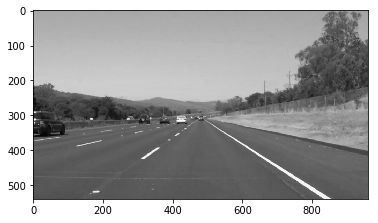

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(gray,cmap='gray')

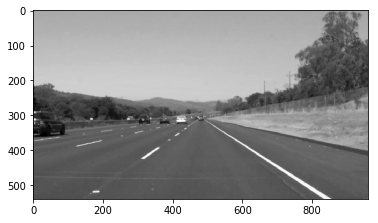

In [3]:
blur_image = blur(gray)
plt.imshow(blur_image,cmap='gray')

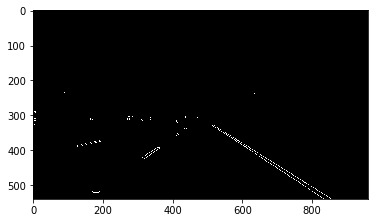

In [4]:
canny_image = canny(blur_image)
plt.imshow(canny_image,cmap='gray')

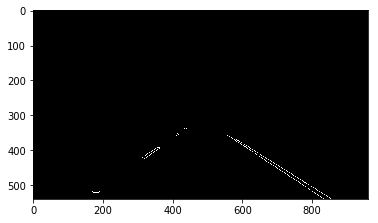

In [5]:
imshape = canny_image.shape
roi_range = np.array([[(0,imshape[0]),(465, 320), (475, 320),(imshape[1],imshape[0])]],dtype = np.int32)
img_masked = roi(canny_image,roi_range)
plt.imshow(img_masked,cmap='gray')

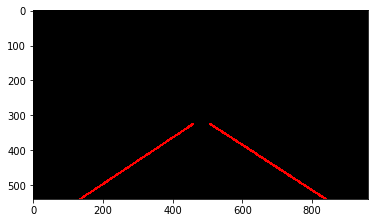

In [6]:
lines = hough_line(img_masked)
line_image = process_line(img_masked,lines)

plt.imshow(line_image,cmap='gray')

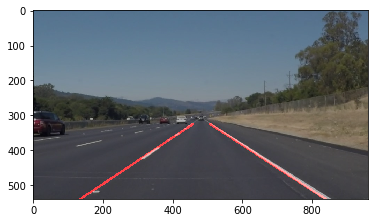

In [7]:
res_image = cv2.addWeighted(image,0.7,line_image,1,0)
plt.imshow(res_image)

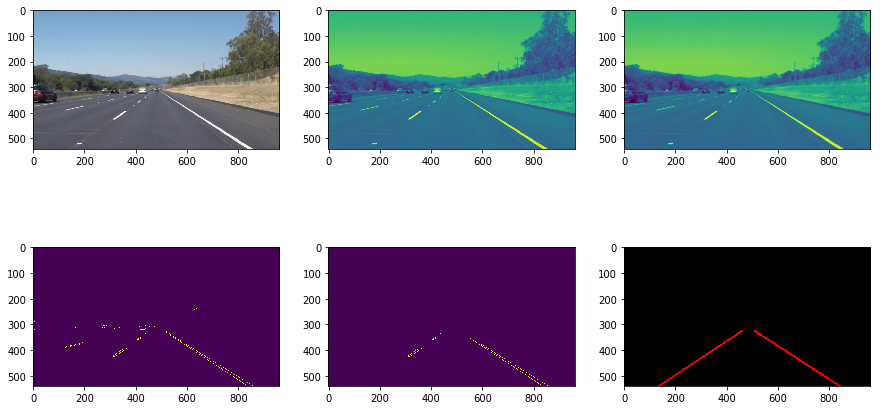

In [8]:
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0) # 显示大小
plt.figure()
plt.subplot(2,3,1)
plt.imshow(image)
plt.subplot(2,3,2)
plt.imshow(gray)
plt.subplot(2,3,3)
plt.imshow(blur_image)
plt.subplot(2,3,4)
plt.imshow(canny_image)
plt.subplot(2,3,5)
plt.imshow(img_masked)
plt.subplot(2,3,6)
plt.imshow(line_image)
plt.show()

In [9]:
process_video('test_videos/solidWhiteRight.mp4')

t:   6%|▌         | 13/221 [00:00<00:01, 127.70it/s, now=None]

Moviepy - Building video ./lane_detection.mp4.
Moviepy - Writing video ./lane_detection.mp4



Moviepy - Done !
Moviepy - video ready ./lane_detection.mp4


In [10]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./lane_detection.mp4'))